In [1]:
def general_conv2d(inputconv, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="conv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d(inputconv, o_d, f_w, s_w, padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv

def general_deconv2d(inputconv, outshape, o_d=64, f_h=7, f_w=7, s_h=1, s_w=1, stddev=0.02, padding="VALID", name="deconv2d", do_norm=True, do_relu=True, relufactor=0):
    with tf.variable_scope(name):
        conv = tf.contrib.layers.conv2d_transpose(inputconv, o_d, [f_h, f_w], [s_h, s_w], padding, activation_fn=None, weights_initializer=tf.truncated_normal_initializer(stddev=stddev),biases_initializer=tf.constant_initializer(0.0))
        conv = tf.nn.relu(conv,"relu")
        return conv
    
def build_resnet_block(inputres, dim, name="resnet"):
    with tf.variable_scope(name):
        out_res = tf.pad(inputres, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c1")
        out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        out_res = general_conv2d(out_res, dim, 3, 3, 1, 1, 0.02, "VALID","c2",do_relu=False)
        return tf.nn.relu(out_res + inputres)
    

In [2]:
def generator(inputgen, name="generator"):
    with tf.variable_scope(name):
        f = 7
        ks = 3
        ngf = 64

        pad_input = tf.pad(inputgen,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c1 = general_conv2d(pad_input, ngf, f, f, 1, 1, 0.02,name="c1")
        o_c2 = general_conv2d(o_c1, ngf*2, ks, ks, 2, 2, 0.02,"SAME","c2")
        o_c3 = general_conv2d(o_c2, ngf*4, ks, ks, 2, 2, 0.02,"SAME","c3")

        o_r1 = build_resnet_block(o_c3, ngf*4, "r1")
        o_r2 = build_resnet_block(o_r1, ngf*4, "r2")
        o_r3 = build_resnet_block(o_r2, ngf*4, "r3")
        o_r4 = build_resnet_block(o_r3, ngf*4, "r4")
        o_r5 = build_resnet_block(o_r4, ngf*4, "r5")
        o_r6 = build_resnet_block(o_r5, ngf*4, "r6")

        o_c4 = general_deconv2d(o_r6, [1,64,64,ngf*2], ngf*2, ks, ks, 2, 2, 0.02,"SAME","c4")
        o_c5 = general_deconv2d(o_c4, [1,128,128,ngf], ngf, ks, ks, 2, 2, 0.02,"SAME","c5")
        o_c5_pad = tf.pad(o_c5,[[0, 0], [ks, ks], [ks, ks], [0, 0]], "REFLECT")
        o_c6 = general_conv2d(o_c5_pad, 3, f, f, 1, 1, 0.02,"VALID","c6",do_relu=False)

        # Adding the tanh layer

        out_gen = tf.nn.tanh(o_c6,"t1")


        return out_gen

In [3]:
def discriminator(inputdisc, name="discriminator"):
    with tf.variable_scope(name):
        f = 4
        ndf = 64

        o_c1 = general_conv2d(inputdisc, ndf, f, f, 2, 2, 0.02, "SAME", "c1", do_norm=False, relufactor=0.2)
        o_c2 = general_conv2d(o_c1, ndf*2, f, f, 2, 2, 0.02, "SAME", "c2", relufactor=0.2)
        o_c3 = general_conv2d(o_c2, ndf*4, f, f, 2, 2, 0.02, "SAME", "c3", relufactor=0.2)
        o_c4 = general_conv2d(o_c3, ndf*8, f, f, 1, 1, 0.02, "SAME", "c4",relufactor=0.2)
        o_c5 = general_conv2d(o_c4, 1, f, f, 1, 1, 0.02, "SAME", "c5",do_norm=False,do_relu=False)

        return o_c5

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

train_a_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainA/*.jpg")    
train_b_files = tf.train.match_filenames_once("/Users/zjucx/Documents/Github/GAN/dataset/input/monet2photo/trainB/*.jpg")    


train_a_queue = tf.train.string_input_producer(train_a_files)
train_b_queue = tf.train.string_input_producer(train_b_files)


image_reader = tf.WholeFileReader()
_, image_a = image_reader.read(train_a_queue)
_, image_b = image_reader.read(train_b_queue)

image_A = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_a),[256,256]),127.5),1)
image_B = tf.subtract(tf.div(tf.image.resize_images(tf.image.decode_jpeg(image_b),[256,256]),127.5),1)


input_A = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_A")
input_B = tf.placeholder(tf.float32, [1, 256, 256, 3], name="input_B")

with tf.variable_scope("Model") as scope:
    gena = generator(input_B, name="g_A")
    genb = generator(input_A, name="g_B")
    dica = discriminator(input_A, name="d_A")
    dicb = discriminator(input_B, name="d_B")
    
    scope.reuse_variables()
    
    cyca = generator(genb, name="g_A")
    cycb = generator(gena, name="g_B")
    dic_gana = discriminator(gena, name="d_A")
    dic_ganb = discriminator(genb, name="d_B")

d_loss_a = (tf.reduce_mean(tf.squared_difference(gena, 1)) + tf.reduce_mean(tf.square(dic_gana)))/2
d_loss_b = (tf.reduce_mean(tf.squared_difference(genb, 1)) + tf.reduce_mean(tf.square(dic_ganb)))/2

cyc_loss = tf.reduce_mean(tf.abs(input_A-cyca)) + tf.reduce_mean(tf.abs(input_B-cycb))

g_loss_a = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_gana, 1))
g_loss_b = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(dic_ganb, 1))

optimizer = tf.train.AdamOptimizer(0.0002, beta1=0.5)

model_vars = tf.trainable_variables()
d_A_vars = [var for var in model_vars if 'd_A' in var.name]
g_A_vars = [var for var in model_vars if 'g_A' in var.name]
d_B_vars = [var for var in model_vars if 'd_B' in var.name]
g_B_vars = [var for var in model_vars if 'g_B' in var.name]

d_A_trainer = optimizer.minimize(d_loss_a, var_list=d_A_vars)
d_B_trainer = optimizer.minimize(d_loss_b, var_list=d_B_vars)
g_A_trainer = optimizer.minimize(g_loss_a, var_list=g_A_vars)
g_B_trainer = optimizer.minimize(g_loss_b, var_list=g_B_vars)

#for var in model_vars: print(var.name)


num0 g_A_trainer:7.868796 d_B_trainer:0.499677 g_B_trainer:7.865993 d_A_trainer0.498723


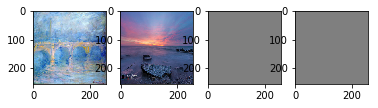

num1 g_A_trainer:7.865965 d_B_trainer:0.499855 g_B_trainer:7.858178 d_A_trainer0.495679
num2 g_A_trainer:7.857656 d_B_trainer:0.498795 g_B_trainer:7.804743 d_A_trainer0.462792
num3 g_A_trainer:7.774268 d_B_trainer:0.481458 g_B_trainer:6.521152 d_A_trainer0.152952
num4 g_A_trainer:11.551588 d_B_trainer:0.340927 g_B_trainer:7.694689 d_A_trainer0.484745
num5 g_A_trainer:7.636724 d_B_trainer:0.389976 g_B_trainer:7.780360 d_A_trainer0.493624


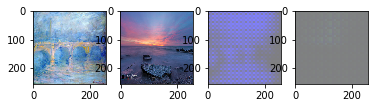

num6 g_A_trainer:7.780086 d_B_trainer:0.380521 g_B_trainer:7.787945 d_A_trainer0.493691
num7 g_A_trainer:7.776927 d_B_trainer:0.357295 g_B_trainer:7.752956 d_A_trainer0.492406
num8 g_A_trainer:7.726929 d_B_trainer:0.340297 g_B_trainer:7.621681 d_A_trainer0.490394
num9 g_A_trainer:7.555874 d_B_trainer:0.334841 g_B_trainer:7.658740 d_A_trainer0.494527
num10 g_A_trainer:10.084917 d_B_trainer:0.333333 g_B_trainer:10.003180 d_A_trainer0.493678


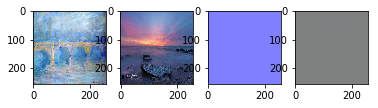

num11 g_A_trainer:10.003775 d_B_trainer:0.333333 g_B_trainer:9.707853 d_A_trainer0.488134
num12 g_A_trainer:9.707853 d_B_trainer:0.333333 g_B_trainer:9.216983 d_A_trainer0.452842
num13 g_A_trainer:9.216983 d_B_trainer:0.333333 g_B_trainer:9.483417 d_A_trainer0.483229
num14 g_A_trainer:9.483417 d_B_trainer:0.333333 g_B_trainer:9.032185 d_A_trainer0.470770
num15 g_A_trainer:9.032185 d_B_trainer:0.333333 g_B_trainer:10.248461 d_A_trainer0.419483


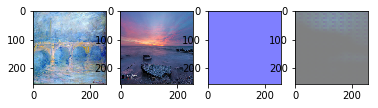

num16 g_A_trainer:10.248461 d_B_trainer:0.333333 g_B_trainer:9.454361 d_A_trainer0.481533
num17 g_A_trainer:9.454361 d_B_trainer:0.333333 g_B_trainer:9.534966 d_A_trainer0.482818
num18 g_A_trainer:9.534966 d_B_trainer:0.333333 g_B_trainer:9.168703 d_A_trainer0.471995
num19 g_A_trainer:9.168703 d_B_trainer:0.333333 g_B_trainer:9.321117 d_A_trainer0.445649
num20 g_A_trainer:9.321117 d_B_trainer:0.333333 g_B_trainer:9.018078 d_A_trainer0.465129


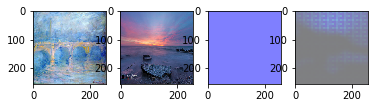

num21 g_A_trainer:9.018078 d_B_trainer:0.333333 g_B_trainer:8.916809 d_A_trainer0.458706
num22 g_A_trainer:8.916809 d_B_trainer:0.333333 g_B_trainer:8.952551 d_A_trainer0.444777
num23 g_A_trainer:8.952551 d_B_trainer:0.333333 g_B_trainer:8.977400 d_A_trainer0.462657
num24 g_A_trainer:8.977400 d_B_trainer:0.333333 g_B_trainer:8.871388 d_A_trainer0.450330
num25 g_A_trainer:8.871388 d_B_trainer:0.333333 g_B_trainer:8.853671 d_A_trainer0.448769


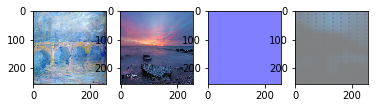

num26 g_A_trainer:8.853671 d_B_trainer:0.333333 g_B_trainer:8.859540 d_A_trainer0.455400
num27 g_A_trainer:8.859540 d_B_trainer:0.333333 g_B_trainer:8.878922 d_A_trainer0.441630
num28 g_A_trainer:8.878922 d_B_trainer:0.333333 g_B_trainer:8.975331 d_A_trainer0.461815
num29 g_A_trainer:8.975331 d_B_trainer:0.333333 g_B_trainer:8.853439 d_A_trainer0.442468
num30 g_A_trainer:8.853439 d_B_trainer:0.333333 g_B_trainer:8.845392 d_A_trainer0.454858


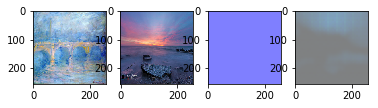

num31 g_A_trainer:8.845392 d_B_trainer:0.333333 g_B_trainer:8.834318 d_A_trainer0.443558
num32 g_A_trainer:8.834318 d_B_trainer:0.333333 g_B_trainer:8.858566 d_A_trainer0.456101
num33 g_A_trainer:8.858566 d_B_trainer:0.333333 g_B_trainer:8.871309 d_A_trainer0.439920
num34 g_A_trainer:8.871309 d_B_trainer:0.333333 g_B_trainer:8.957758 d_A_trainer0.460968
num35 g_A_trainer:8.957758 d_B_trainer:0.333333 g_B_trainer:8.833950 d_A_trainer0.442039


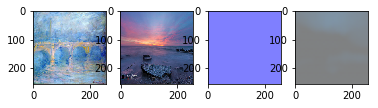

num36 g_A_trainer:8.833950 d_B_trainer:0.333333 g_B_trainer:8.820212 d_A_trainer0.452068
num37 g_A_trainer:8.820212 d_B_trainer:0.333333 g_B_trainer:8.819633 d_A_trainer0.443090
num38 g_A_trainer:8.819633 d_B_trainer:0.333333 g_B_trainer:8.860617 d_A_trainer0.456077
num39 g_A_trainer:8.860617 d_B_trainer:0.333333 g_B_trainer:8.914164 d_A_trainer0.436526
num40 g_A_trainer:8.914164 d_B_trainer:0.333333 g_B_trainer:9.178457 d_A_trainer0.468509


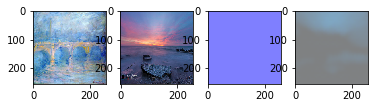

num41 g_A_trainer:9.178457 d_B_trainer:0.333333 g_B_trainer:8.810419 d_A_trainer0.450186
num42 g_A_trainer:8.810419 d_B_trainer:0.333333 g_B_trainer:9.135463 d_A_trainer0.424635
num43 g_A_trainer:9.135463 d_B_trainer:0.333333 g_B_trainer:9.384736 d_A_trainer0.472251
num44 g_A_trainer:9.384736 d_B_trainer:0.333333 g_B_trainer:9.351947 d_A_trainer0.470558
num45 g_A_trainer:9.351947 d_B_trainer:0.333333 g_B_trainer:8.855743 d_A_trainer0.450180


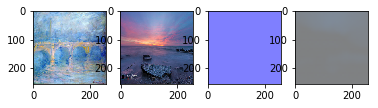

num46 g_A_trainer:8.855743 d_B_trainer:0.333333 g_B_trainer:9.285702 d_A_trainer0.414909
num47 g_A_trainer:9.285702 d_B_trainer:0.333333 g_B_trainer:9.236648 d_A_trainer0.465536
num48 g_A_trainer:9.236648 d_B_trainer:0.333333 g_B_trainer:9.189057 d_A_trainer0.463557
num49 g_A_trainer:9.189057 d_B_trainer:0.333333 g_B_trainer:8.804651 d_A_trainer0.442412
num50 g_A_trainer:8.804651 d_B_trainer:0.333333 g_B_trainer:8.965548 d_A_trainer0.424890


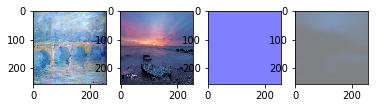

num51 g_A_trainer:8.965548 d_B_trainer:0.333333 g_B_trainer:9.553499 d_A_trainer0.468715
num52 g_A_trainer:9.553499 d_B_trainer:0.333333 g_B_trainer:8.860999 d_A_trainer0.440215
num53 g_A_trainer:8.860999 d_B_trainer:0.333333 g_B_trainer:9.307996 d_A_trainer0.391109
num54 g_A_trainer:9.307996 d_B_trainer:0.333333 g_B_trainer:9.422758 d_A_trainer0.461415
num55 g_A_trainer:9.422758 d_B_trainer:0.333333 g_B_trainer:9.428606 d_A_trainer0.461585


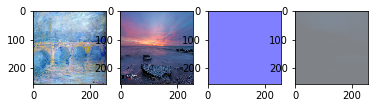

num56 g_A_trainer:9.428606 d_B_trainer:0.333333 g_B_trainer:9.008545 d_A_trainer0.443753
num57 g_A_trainer:9.008545 d_B_trainer:0.333333 g_B_trainer:9.153411 d_A_trainer0.394855
num58 g_A_trainer:9.153411 d_B_trainer:0.333333 g_B_trainer:9.036657 d_A_trainer0.443560
num59 g_A_trainer:9.036657 d_B_trainer:0.333333 g_B_trainer:8.883206 d_A_trainer0.434880
num60 g_A_trainer:8.883206 d_B_trainer:0.333333 g_B_trainer:8.880084 d_A_trainer0.407165


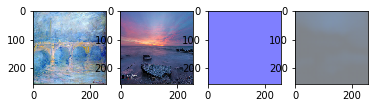

num61 g_A_trainer:8.880084 d_B_trainer:0.333333 g_B_trainer:8.787894 d_A_trainer0.429813
num62 g_A_trainer:8.787894 d_B_trainer:0.333333 g_B_trainer:8.737468 d_A_trainer0.428042
num63 g_A_trainer:8.737468 d_B_trainer:0.333333 g_B_trainer:8.719886 d_A_trainer0.426283
num64 g_A_trainer:8.719886 d_B_trainer:0.333333 g_B_trainer:8.825284 d_A_trainer0.443842
num65 g_A_trainer:8.825284 d_B_trainer:0.333333 g_B_trainer:9.082739 d_A_trainer0.410198


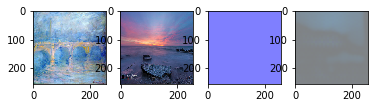

num66 g_A_trainer:9.082739 d_B_trainer:0.333333 g_B_trainer:9.180893 d_A_trainer0.458412
num67 g_A_trainer:9.180893 d_B_trainer:0.333333 g_B_trainer:8.988592 d_A_trainer0.453201
num68 g_A_trainer:8.988592 d_B_trainer:0.333333 g_B_trainer:8.750263 d_A_trainer0.426742
num69 g_A_trainer:8.750263 d_B_trainer:0.333333 g_B_trainer:8.690531 d_A_trainer0.438644
num70 g_A_trainer:8.690531 d_B_trainer:0.333333 g_B_trainer:8.682323 d_A_trainer0.442494


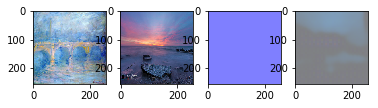

num71 g_A_trainer:8.682323 d_B_trainer:0.333333 g_B_trainer:8.677939 d_A_trainer0.440173
num72 g_A_trainer:8.677939 d_B_trainer:0.333333 g_B_trainer:8.722137 d_A_trainer0.454228
num73 g_A_trainer:8.722137 d_B_trainer:0.333333 g_B_trainer:8.820611 d_A_trainer0.421471
num74 g_A_trainer:8.820611 d_B_trainer:0.333333 g_B_trainer:8.832525 d_A_trainer0.460497
num75 g_A_trainer:8.832525 d_B_trainer:0.333333 g_B_trainer:8.682381 d_A_trainer0.448107


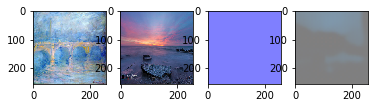

num76 g_A_trainer:8.682381 d_B_trainer:0.333333 g_B_trainer:8.743099 d_A_trainer0.432996
num77 g_A_trainer:8.743099 d_B_trainer:0.333333 g_B_trainer:8.748531 d_A_trainer0.450679
num78 g_A_trainer:8.748531 d_B_trainer:0.333333 g_B_trainer:8.667356 d_A_trainer0.434619
num79 g_A_trainer:8.667356 d_B_trainer:0.333333 g_B_trainer:8.667599 d_A_trainer0.444589
num80 g_A_trainer:8.667599 d_B_trainer:0.333333 g_B_trainer:8.679811 d_A_trainer0.451095


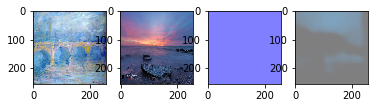

num81 g_A_trainer:8.679811 d_B_trainer:0.333333 g_B_trainer:8.722882 d_A_trainer0.427933
num82 g_A_trainer:8.722882 d_B_trainer:0.333333 g_B_trainer:8.745445 d_A_trainer0.456104
num83 g_A_trainer:8.745445 d_B_trainer:0.333333 g_B_trainer:8.669847 d_A_trainer0.441471
num84 g_A_trainer:8.669847 d_B_trainer:0.333333 g_B_trainer:8.667742 d_A_trainer0.439140
num85 g_A_trainer:8.667742 d_B_trainer:0.333333 g_B_trainer:8.670123 d_A_trainer0.442323


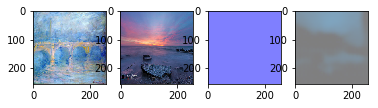

num86 g_A_trainer:8.670123 d_B_trainer:0.333333 g_B_trainer:8.661360 d_A_trainer0.426868
num87 g_A_trainer:8.661360 d_B_trainer:0.333333 g_B_trainer:8.656252 d_A_trainer0.444739
num88 g_A_trainer:8.656252 d_B_trainer:0.333333 g_B_trainer:8.649048 d_A_trainer0.439324
num89 g_A_trainer:8.649048 d_B_trainer:0.333333 g_B_trainer:8.643805 d_A_trainer0.444595
num90 g_A_trainer:8.643805 d_B_trainer:0.333333 g_B_trainer:8.639543 d_A_trainer0.445482


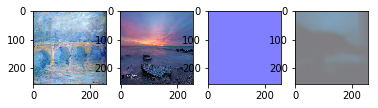

num91 g_A_trainer:8.639543 d_B_trainer:0.333333 g_B_trainer:8.643138 d_A_trainer0.444282
num92 g_A_trainer:8.643138 d_B_trainer:0.333333 g_B_trainer:8.651692 d_A_trainer0.449049
num93 g_A_trainer:8.651692 d_B_trainer:0.333333 g_B_trainer:8.646970 d_A_trainer0.445924
num94 g_A_trainer:8.646970 d_B_trainer:0.333333 g_B_trainer:8.641294 d_A_trainer0.444887
num95 g_A_trainer:8.641294 d_B_trainer:0.333333 g_B_trainer:8.642097 d_A_trainer0.438807


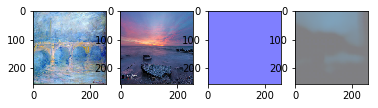

num96 g_A_trainer:8.642097 d_B_trainer:0.333333 g_B_trainer:8.643525 d_A_trainer0.445018
num97 g_A_trainer:8.643525 d_B_trainer:0.333333 g_B_trainer:8.640650 d_A_trainer0.441203
num98 g_A_trainer:8.640650 d_B_trainer:0.333333 g_B_trainer:8.638596 d_A_trainer0.448397
num99 g_A_trainer:8.638596 d_B_trainer:0.333333 g_B_trainer:8.634152 d_A_trainer0.443380


In [5]:
with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    
    # Loading images into the tensors
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    imga = sess.run(image_A).reshape((1, 256, 256, 3))
    imgb = sess.run(image_B).reshape((1, 256, 256, 3))
    for epoch in range(0,101):
        
        # Optimizing the G_A network
        _, a, imggena, imggenb = sess.run([g_A_trainer, g_loss_a, genb, gena],feed_dict={input_A:imga, input_B:imgb})
        _, b = sess.run([d_B_trainer, d_loss_b],feed_dict={input_A:imga, input_B:imgb})
        _, c = sess.run([g_B_trainer, g_loss_b],feed_dict={input_A:imga, input_B:imgb})
        _, d = sess.run([d_A_trainer, d_loss_a],feed_dict={input_A:imga, input_B:imgb})

        print("num%d g_A_trainer:%f d_B_trainer:%f g_B_trainer:%f d_A_trainer%f"%(epoch, a, b, c, d))
        if epoch%2 == 0:
            plt.subplot(141); plt.imshow(((imga.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(142); plt.imshow(((imgb.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(143); plt.imshow(((imggena.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.subplot(144); plt.imshow(((imggenb.reshape((256, 256, 3))+1)*127.5).astype(np.uint8))
            plt.show()
    coord.request_stop()
    coord.join(threads)